# TorchVision Object Detection Finetuning Tutorial
For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

## Defining the Dataset
The reference scripts for training object detection, instance segmentation and person keypoint detection allows for easily supporting adding new custom datasets. The dataset should inherit from the standard torch.utils.data.Dataset class, and implement ``__len__`` and ``__getitem__``.

The only specificity that we require is that the dataset ``__getitem__`` should return:

* image: a PIL Image of size ``(H, W)``
* target: a dict containing the following fields
    * ``boxes (FloatTensor[N, 4])``: the coordinates of the ``N`` bounding boxes in ``[x0, y0, x1, y1]`` format, ranging from 0 to W and 0 to H
    * ``labels (Int64Tensor[N])``: the label for each bounding box. 0 represents always the background class.
    * ``image_id (Int64Tensor[1])``: an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * ``area (Tensor[N])``: The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * ``iscrowd (UInt8Tensor[N])``: instances with iscrowd=True will be ignored during evaluation.
    * (optionally) ``masks (UInt8Tensor[N, H, W])``: The segmentation masks for each one of the objects
    * (optionally) ``keypoints (FloatTensor[N, K, 3])``: For each one of the N objects, it contains the K keypoints in ``[x, y, visibility]`` format, defining the object. visibility=0 means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt ``references/detection/transforms.py`` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from ``pycocotools``.

One note on the ``labels``. The model considers class ``0`` as background. If your dataset does not contain the background class, you should not have ``0`` in your ``labels``. For example, assuming you have just two classes, cat and dog, you can define ``1`` (not ``0``) to represent cats and ``2`` to represent dogs. So, for instance, if one of the images has booth classes, your ``labels`` tensor should look like ``[1,2]``.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a ``get_height_and_width`` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via ``__getitem__`` , which loads the image in memory and is slower than if a custom method is provided.

Writing a custom dataset for PennFudan
Let’s write a dataset for the PennFudan dataset. After downloading and extracting the zip file, we have the following folder structure:

## Writing a custom dataset for PennFudan
Let’s write a dataset for the PennFudan dataset. After [downloading and extracting the zip file](https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip), we have the following folder structure:

```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```
Here is one example of a pair of images and segmentation masks
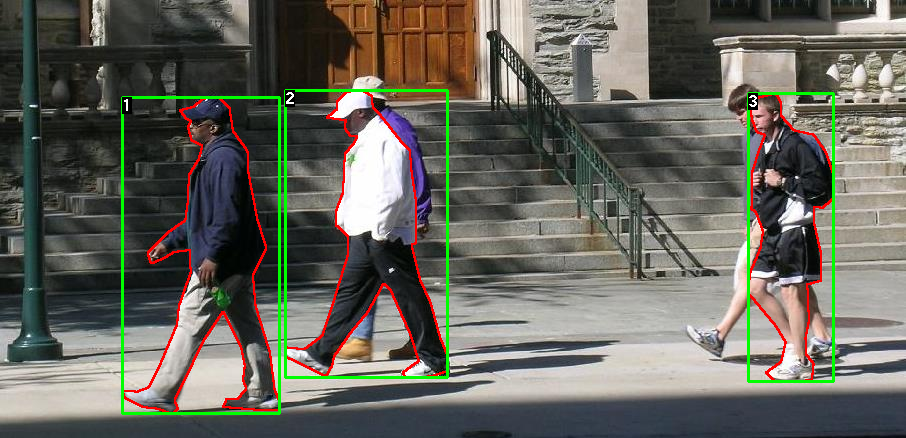

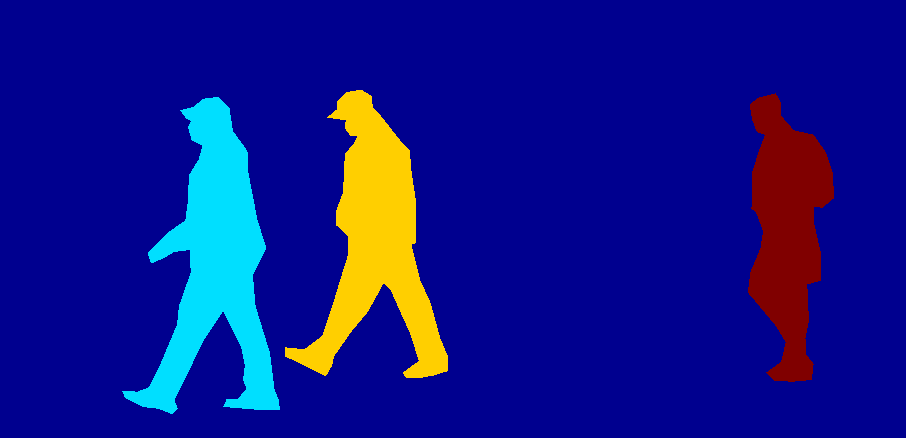
So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let’s write a ``torch.utils.data.Dataset`` class for this dataset.

In [1]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

That’s all for the dataset. Now let’s define a model that can perform predictions on this dataset.

## Defining your model
In this tutorial, we will be using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.
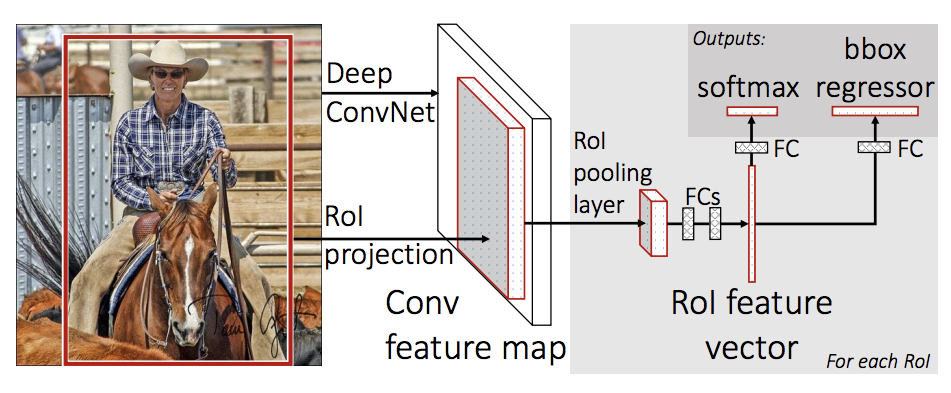
Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

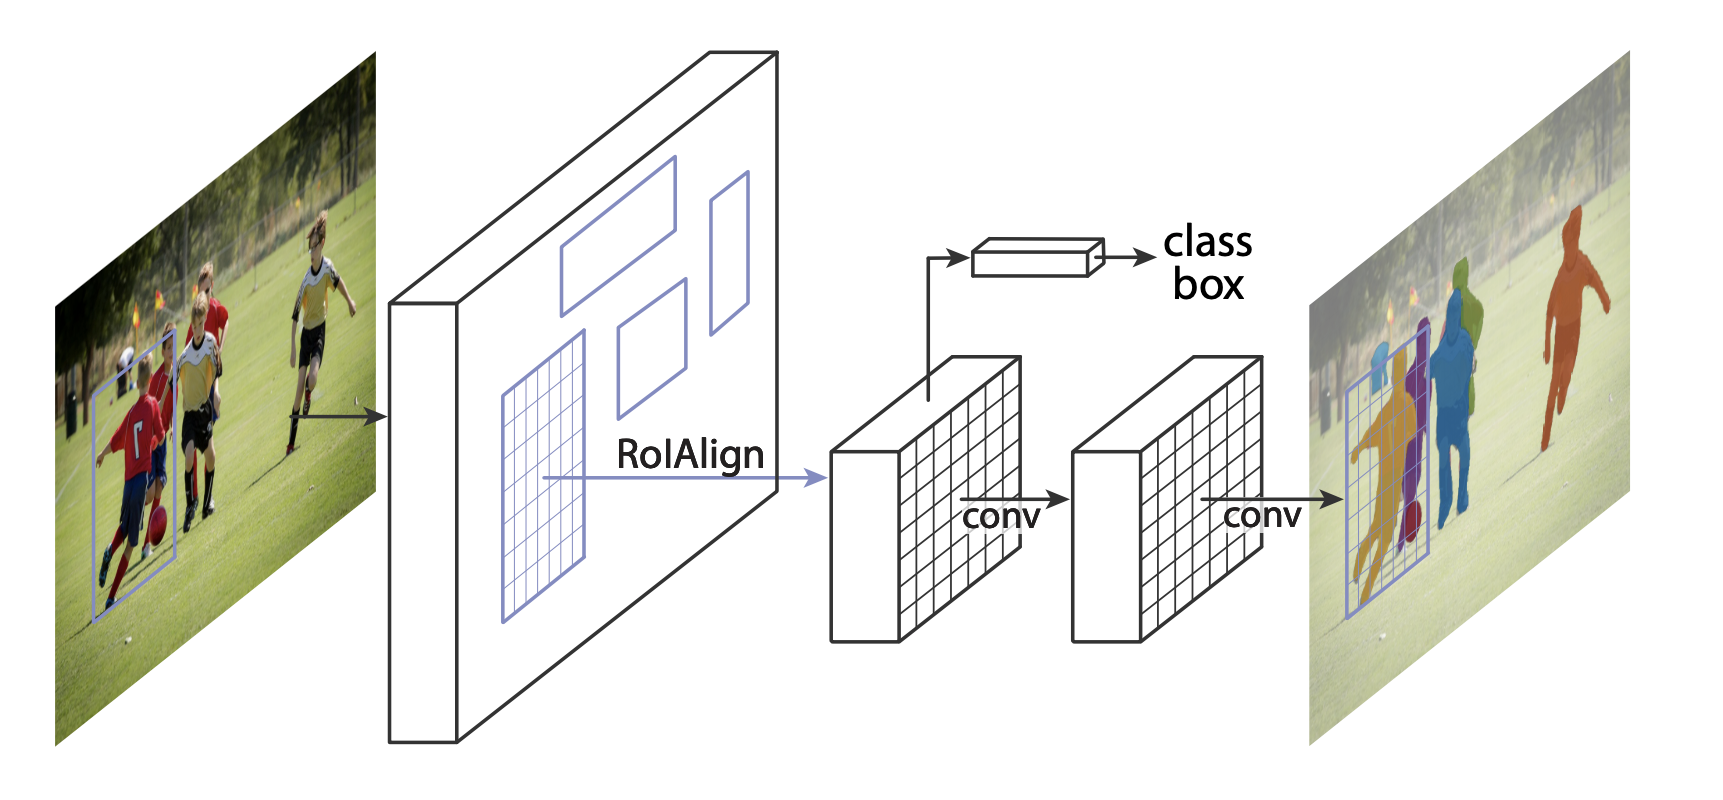

There are two common situations where one might want to modify one of the available models in torchvision modelzoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

Let’s go see how we would do one or another in the following sections.

### 1 - Finetuning from a pretrained model
Let’s suppose that you want to start from a model pre-trained on COCO and want to finetune it for your particular classes. Here is a possible way of doing it:

In [2]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2 - Modifying the model to add a different backbone

In [3]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

## An Instance segmentation model for PennFudan Dataset
In our case, we want to fine-tune from a pre-trained model, given that our dataset is very small, so we will be following approach number 1.

Here we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

That’s it, this will make ``model`` be ready to be trained and evaluated on your custom dataset.

## Putting everything together
In ``references/detection/``, we have a number of helper functions to simplify training and evaluating detection models. Here, we will use ``references/detection/engine.py``, ``references/detection/utils.py`` and ``references/detection/transforms.py``. Just copy them to your folder and use them here.

Let’s write some helper functions for data augmentation / transformation:

In [5]:
import sys
sys.path.append("./references")
sys.path.append("./references/detection")

import transforms as T


def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## Testing forward() method (Optional)
Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

In [6]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/home1/yanp/Apps/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1587428266983/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Let’s now write the main function which performs the training and the validation:

In [7]:
from engine import train_one_epoch, evaluate
import utils


def main():
    # train on the GPU or on the CPU, if a GPU is not available
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # our dataset has two classes only - background and person
    num_classes = 2
    # use our dataset and defined transformations
    dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # get the model using our helper function
    model = get_model_instance_segmentation(num_classes)

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        
        # cuda is required by evaluate()
        if torch.cuda.is_available():
            # evaluate on the test dataset
            evaluate(model, data_loader_test, device=device)

    print("That's it!")

In [8]:
main()

/home1/yanp/Apps/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Epoch: [0]  [ 0/60]  eta: 0:00:51  lr: 0.000090  loss: 3.4389 (3.4389)  loss_classifier: 0.5497 (0.5497)  loss_box_reg: 0.0670 (0.0670)  loss_mask: 2.8018 (2.8018)  loss_objectness: 0.0171 (0.0171)  loss_rpn_box_reg: 0.0033 (0.0033)  time: 0.8504  data: 0.3746  max mem: 1918
Epoch: [0]  [10/60]  eta: 0:00:19  lr: 0.000936  loss: 1.2830 (1.7618)  loss_classifier: 0.4078 (0.3854)  loss_box_reg: 0.1804 (0.1751)  loss_mask: 0.6078 (1.1714)  loss_objectness: 0.0171 (0.0191)  loss_rpn_box_reg: 0.0082 (0.0108)  time: 0.3845  data: 0.0391  max mem: 3511
Epoch: [0]  [20/60]  eta: 0:00:14  lr: 0.001783  loss: 0.7089 (1.2008)  loss_classifier: 0.1720 (0.2675)  loss_box_reg: 0.1592 (0.1703)  loss_mask: 0.3295 (0.7359)  loss_objectness: 0.0137 (0.0157)  loss_rpn_box_reg: 0.0082 (0.0114)  time: 0.3311  data: 0.0050  max mem: 3511
Epoch: [0]  [30/60]  eta: 0:00:10  lr: 0.002629  loss: 0.5003 (0.9479)  loss_classifier: 0.0929 (0.2038)  loss_box_reg: 0.1267 (0.1588)  loss_mask: 0.2138 (0.5616)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:00:41  lr: 0.005000  loss: 0.1850 (0.1850)  loss_classifier: 0.0315 (0.0315)  loss_box_reg: 0.0181 (0.0181)  loss_mask: 0.1164 (0.1164)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0168 (0.0168)  time: 0.6940  data: 0.3544  max mem: 3511
Epoch: [2]  [10/60]  eta: 0:00:18  lr: 0.005000  loss: 0.1986 (0.2211)  loss_classifier: 0.0328 (0.0406)  loss_box_reg: 0.0188 (0.0250)  loss_mask: 0.1316 (0.1399)  loss_objectness: 0.0005 (0.0011)  loss_rpn_box_reg: 0.0112 (0.0144)  time: 0.3760  data: 0.0364  max mem: 3511
Epoch: [2]  [20/60]  eta: 0:00:13  lr: 0.005000  loss: 0.1986 (0.2144)  loss_classifier: 0.0320 (0.0354)  loss_box_reg: 0.0175 (0.0234)  loss_mask: 0.1316 (0.1417)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0104 (0.0128)  time: 0.3270  data: 0.0044  max mem: 3511
Epoch: [2]  [30/60]  eta: 0:00:10  lr: 0.005000  loss: 0.1704 (0.2036)  loss_classifier: 0.0230 (0.0341)  loss_box_reg: 0.0135 (0.0210)  loss_mask: 0.1189 (0.1360)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:00:44  lr: 0.000500  loss: 0.1608 (0.1608)  loss_classifier: 0.0335 (0.0335)  loss_box_reg: 0.0131 (0.0131)  loss_mask: 0.1054 (0.1054)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0083 (0.0083)  time: 0.7402  data: 0.3868  max mem: 3511
Epoch: [4]  [10/60]  eta: 0:00:17  lr: 0.000500  loss: 0.1513 (0.1497)  loss_classifier: 0.0239 (0.0248)  loss_box_reg: 0.0097 (0.0095)  loss_mask: 0.1054 (0.1080)  loss_objectness: 0.0004 (0.0008)  loss_rpn_box_reg: 0.0057 (0.0066)  time: 0.3494  data: 0.0381  max mem: 3511
Epoch: [4]  [20/60]  eta: 0:00:13  lr: 0.000500  loss: 0.1513 (0.1536)  loss_classifier: 0.0218 (0.0248)  loss_box_reg: 0.0096 (0.0096)  loss_mask: 0.1061 (0.1119)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0061 (0.0065)  time: 0.3193  data: 0.0038  max mem: 3511
Epoch: [4]  [30/60]  eta: 0:00:10  lr: 0.000500  loss: 0.1531 (0.1635)  loss_classifier: 0.0261 (0.0262)  loss_box_reg: 0.0105 (0.0109)  loss_mask: 0.1147 (0.1184)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:00:42  lr: 0.000050  loss: 0.1461 (0.1461)  loss_classifier: 0.0183 (0.0183)  loss_box_reg: 0.0077 (0.0077)  loss_mask: 0.1142 (0.1142)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0059 (0.0059)  time: 0.7142  data: 0.3750  max mem: 3511
Epoch: [6]  [10/60]  eta: 0:00:18  lr: 0.000050  loss: 0.1460 (0.1542)  loss_classifier: 0.0224 (0.0242)  loss_box_reg: 0.0090 (0.0103)  loss_mask: 0.1090 (0.1121)  loss_objectness: 0.0002 (0.0010)  loss_rpn_box_reg: 0.0059 (0.0067)  time: 0.3659  data: 0.0367  max mem: 3511
Epoch: [6]  [20/60]  eta: 0:00:13  lr: 0.000050  loss: 0.1528 (0.1560)  loss_classifier: 0.0232 (0.0235)  loss_box_reg: 0.0096 (0.0109)  loss_mask: 0.1080 (0.1144)  loss_objectness: 0.0002 (0.0007)  loss_rpn_box_reg: 0.0062 (0.0066)  time: 0.3288  data: 0.0037  max mem: 3511
Epoch: [6]  [30/60]  eta: 0:00:10  lr: 0.000050  loss: 0.1528 (0.1540)  loss_classifier: 0.0217 (0.0230)  loss_box_reg: 0.0090 (0.0103)  loss_mask: 0.1080 (0.1134)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:00:49  lr: 0.000050  loss: 0.2227 (0.2227)  loss_classifier: 0.0533 (0.0533)  loss_box_reg: 0.0216 (0.0216)  loss_mask: 0.1326 (0.1326)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 0.8175  data: 0.4030  max mem: 3511
Epoch: [8]  [10/60]  eta: 0:00:18  lr: 0.000050  loss: 0.1345 (0.1478)  loss_classifier: 0.0202 (0.0237)  loss_box_reg: 0.0068 (0.0078)  loss_mask: 0.1037 (0.1090)  loss_objectness: 0.0003 (0.0015)  loss_rpn_box_reg: 0.0056 (0.0059)  time: 0.3727  data: 0.0396  max mem: 3511
Epoch: [8]  [20/60]  eta: 0:00:14  lr: 0.000050  loss: 0.1388 (0.1484)  loss_classifier: 0.0190 (0.0215)  loss_box_reg: 0.0066 (0.0083)  loss_mask: 0.1037 (0.1116)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0046 (0.0057)  time: 0.3272  data: 0.0039  max mem: 3511
Epoch: [8]  [30/60]  eta: 0:00:10  lr: 0.000050  loss: 0.1609 (0.1542)  loss_classifier: 0.0202 (0.0231)  loss_box_reg: 0.0108 (0.0097)  loss_mask: 0.1181 (0.1141)  loss_ob

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset. For that, you wrote a ``torch.utils.data.Dataset`` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check ``references/detection/train.py``, which is present in the torchvision repo.

You can download a full source file for this tutorial [here](https://pytorch.org/tutorials/_static/tv-training-code.py).

(-0.5, 1123.5, 539.5, -0.5)

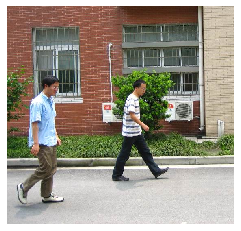

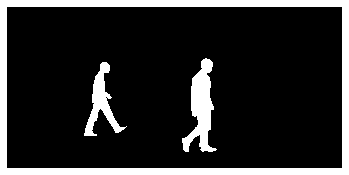

In [284]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('/home1/yanp/Workspace/envs/Tensorboard/runs/object_detaction_fine_turning_exp_1')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
img, tar = dataset.__getitem__(0)

origin_image = img
image_masks = tar["masks"].float()
image_masks = torch.unsqueeze(image_masks, 1)


# create grid of images
img_grid = torchvision.utils.make_grid(image_masks)

# write to tensorboard
writer.add_image('original_image', origin_image)
writer.add_image('image_masks', img_grid)


fig1 = plt.figure()
plt.imshow(np.transpose(origin_image, (1,2,0)))
plt.axis('off')

fig2 = plt.figure()
plt.imshow(np.transpose(img_grid, (1,2,0)))
plt.axis('off')


boxes
tensor([[147.,  84., 238., 365.],
        [232.,  53., 336., 359.],
        [329.,  74., 454., 365.]], device='cuda:0')
labels
tensor([1, 1, 1], device='cuda:0')
image_id
tensor([154], device='cuda:0')
area
tensor([25571., 31824., 36375.], device='cuda:0')
iscrowd
tensor([0, 0, 0], device='cuda:0')
boxes
tensor([[ 29., 117., 166., 412.],
        [119., 148., 256., 412.],
        [215., 151., 353., 415.],
        [704., 128., 838., 389.],
        [344., 161., 423., 341.]], device='cuda:0')
labels
tensor([1, 1, 1, 1, 1], device='cuda:0')
image_id
tensor([95], device='cuda:0')
area
tensor([40415., 36168., 36432., 34974., 14220.], device='cuda:0')
iscrowd
tensor([0, 0, 0, 0, 0], device='cuda:0')
MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_s

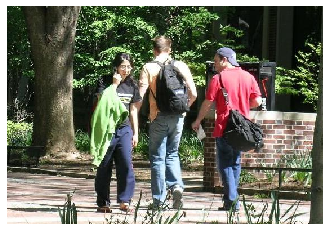

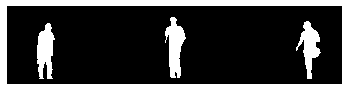

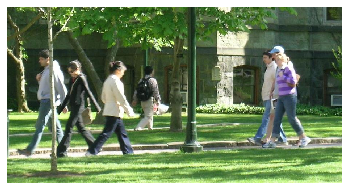

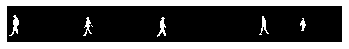

In [343]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)


# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

images, targets = iter(data_loader).next()
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for i in range(len(images)):
    img = images[i]
    img = img.cpu().numpy()
    plt.figure()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.axis('off')
    tgt = targets[i]
    igrid = torchvision.utils.make_grid(torch.unsqueeze(tgt['masks'].float(), 1))
    fig = plt.figure()
    plt.imshow(np.transpose(igrid.cpu(), (1,2,0)))
    plt.axis('off')
    for k in tgt:
        if k != "masks":
            print(k)
            print(tgt[k])

images[0].to(device)
targets[0]['masks'].to(device)

img = images[0]
tgt = targets[0]

# model([img], [tgt])

print(model)
# writer.add_graph(model, [img] )

